In [1]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from random import shuffle
import albumentations as A
import torch
torch.__version__
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from torchvision.datasets import STL10
import torchvision.transforms.functional as tvf
from torchvision import transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, SequentialSampler
import random
from PIL import Image
from torch.multiprocessing import cpu_count
from torch.optim import RMSprop
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from argparse import Namespace

class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
    
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss
    
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        
        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
       
        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
     
        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss


img_dirs = []
labels_temp = []
additional_data = []
bad_type1_txt = '/workstation/home/bijoy/data_from_b170007ec/Programs/Cervix Cancer/bad_files1.txt'
bad_type2_txt = '/workstation/home/bijoy/data_from_b170007ec/Programs/Cervix Cancer/files2bad.txt'
bad_type3_txt = '/workstation/home/bijoy/data_from_b170007ec/Programs/Cervix Cancer/bad_files3.txt'
for class_,txt in enumerate([bad_type1_txt,bad_type2_txt,bad_type3_txt]):
    for i,dir_ in enumerate(pickle.load(open(txt,'rb'))):
        dir_ = dir_.split('/')
        dir_[0] = '/workstation'
        dir_[1] = 'home'
        dir_.insert(2,'bijoy')
        dir_.insert(3,'data_from_b170007ec')
        dir_.insert(6,'train')
        if 'additional' in dir_[-3].split('_'):
            dir_.remove(dir_[-2])
        else:
            dir_.remove(dir_[-3])
        dir_ = '/'.join(dir_)
        additional_data.append(dir_)
print("Length of additional data :",len(additional_data))

type1_txt = '/workstation/home/bijoy/data_from_b170007ec/Programs/Cervix Cancer/good_files1.txt'
type2_txt = '/workstation/home/bijoy/data_from_b170007ec/Programs/Cervix Cancer/files2good.txt'
type3_txt = '/workstation/home/bijoy/data_from_b170007ec/Programs/Cervix Cancer/good_files3.txt'
for class_,txt in enumerate([type1_txt,type2_txt,type3_txt]):
    for i,dir_ in enumerate(pickle.load(open(txt,'rb'))):
        dir_ = dir_.split('/')
        dir_[0] = '/workstation'
        dir_[1] = 'home'
        dir_.insert(2,'bijoy')
        dir_.insert(3,'data_from_b170007ec')
        dir_.insert(6,'train')
        if 'additional' in dir_[-3].split('_'):
            dir_.remove(dir_[-2])
        else:
            dir_.remove(dir_[-3])
        dir_ = '/'.join(dir_)
        img_dirs.append(dir_)
        labels_temp.append(0)

files = os.listdir("/workstation/home/bijoy/data_from_b170007ec/Programs/Bhanu/SCLEARNING/Imagenet/val")
files = sorted(files)
for i in files[1:]:
    path = "/workstation/home/bijoy/data_from_b170007ec/Programs/Bhanu/SCLEARNING/Imagenet/val/" + str(i)
    img = Image.open(path)
    t2 = transforms.ToTensor()(img)
    if t2.shape[0] == 3:
        img_dirs.append(path)
        labels_temp.append(1)    
data_temp = img_dirs

temp = list(zip(data_temp, labels_temp))
random.shuffle(temp)
data, labels = zip(*temp)
# data = data_temp
# labels = labels_temp
print("Length of data :",len(data))
print("Length of labels :",len(labels))

def random_rotate(image):
    if random.random() > 0.5:
        return tvf.rotate(image, angle=random.choice((0, 90, 180, 270)))
    return image

class ResizedRotation():
    def __init__(self, angle, output_size=(512,512)):
        self.angle = angle
        self.output_size = output_size
        
    def angle_to_rad(self, ang): return np.pi * ang / 180.0
        
    def __call__(self, image):
        w, h = image.size
        new_h = int(np.abs(w * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(h * np.sin(self.angle_to_rad(self.angle))))
        new_w = int(np.abs(h * np.sin(self.angle_to_rad(90 - self.angle))) + np.abs(w * np.sin(self.angle_to_rad(self.angle))))
        img = tvf.resize(image, (new_w, new_h))
        img = tvf.rotate(img, self.angle)
        img = tvf.center_crop(img, self.output_size)
        return img
    
class WrapWithRandomParams():
    def __init__(self, constructor, ranges):
        self.constructor = constructor
        self.ranges = ranges
    
    def __call__(self, image):
        randoms = [float(np.random.uniform(low, high)) for _, (low, high) in zip(range(len(self.ranges)), self.ranges)]
        return self.constructor(*randoms)(image)
    
class PretrainingDatasetWrapper(Dataset):
    def __init__(self, ds: Dataset, l: labels, target_size=(512,512), debug=False):
        super().__init__()
        self.ds = ds
        self.labels = l
        self.debug = debug
        self.target_size = target_size
        if debug:
            print("DATASET IN DEBUG MODE")
        
        # I will be using network pre-trained on ImageNet first, which uses this normalization.
        # Remove this, if you're training from scratch or apply different transformations accordingly
        self.preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        random_resized_rotation = WrapWithRandomParams(lambda angle: ResizedRotation(angle, target_size), [(0.0, 360.0)])
        self.randomize = transforms.Compose([
            transforms.RandomResizedCrop(target_size, scale=(340/512, 340/512), ratio=(1.0, 1.0)),
            transforms.RandomChoice([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Lambda(random_rotate)
            ]),
            transforms.RandomApply([
                random_resized_rotation
            ], p=0.6),
            transforms.RandomApply([
                transforms.ColorJitter(brightness=0.5, contrast=0.6, saturation=0.6, hue=0.3)
            ], p=0.8)
        ])
    
    def __len__(self): return len(self.ds)
    
    def __getitem_internal__(self, idx, preprocess=True):
        this_image_raw_path = self.ds[idx]
        label = self.labels[idx]
        this_image_raw = Image.open(this_image_raw_path)
        if self.debug:
            random.seed(idx)
            t1 = self.randomize(this_image_raw)
            random.seed(idx + 1)
            t2 = self.randomize(this_image_raw)
        else:
            t1 = self.randomize(this_image_raw)
            t2 = self.randomize(this_image_raw)
        
        if preprocess:
            t1 = self.preprocess(t1)
            t2 = self.preprocess(t2)
        else:
            t1 = transforms.ToTensor()(t1)
            t2 = transforms.ToTensor()(t2)
            
        return (t1, t2), torch.tensor(label)

    def __getitem__(self, idx):
        return self.__getitem_internal__(idx, True)
    
    def raw(self, idx):
        return self.__getitem_internal__(idx, False)
    
    
from efficientnet_pytorch import EfficientNet
class ImageEmbedding(nn.Module):       
    class Identity(nn.Module):
        def __init__(self): super().__init__()

        def forward(self, x):
            return x
    
        
    def __init__(self, embedding_size=1024):
        super().__init__()
        
        base_model = EfficientNet.from_pretrained("efficientnet-b2")
        internal_embedding_size = base_model._fc.in_features
        base_model._fc = ImageEmbedding.Identity()
        
        self.embedding = base_model
        
        self.projection = nn.Sequential(
            nn.Linear(in_features=internal_embedding_size, out_features=embedding_size),
            nn.ReLU(),
            nn.Linear(in_features=embedding_size, out_features=embedding_size)
        )

    def calculate_embedding(self, image):
        return self.embedding(image)

    def forward(self, X):
        image = X
        embedding = self.calculate_embedding(image)
        projection = self.projection(embedding)
        return embedding, projection

    
class ImageEmbeddingModule(pl.LightningModule):
    def __init__(self, hparams):
        hparams = Namespace(**hparams) if isinstance(hparams, dict) else hparams
        super().__init__()
        self.hparams = hparams
        self.model = ImageEmbedding()
        self.loss = SupConLoss()
    
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.epochs
    
    def train_dataloader(self):
        return DataLoader(PretrainingDatasetWrapper(data, labels,
                                             debug=getattr(self.hparams, "debug", False)),
                          batch_size=self.hparams.batch_size,
                          num_workers=4,
                          sampler=SubsetRandomSampler(list(range(hparams.train_size))),
                         drop_last=True)
    
    def val_dataloader(self):
        return DataLoader(PretrainingDatasetWrapper(data, labels,
                                            debug=getattr(self.hparams, "debug", False)),
                          batch_size=self.hparams.batch_size, 
                          shuffle=False,
                          num_workers=4,
                          sampler=SequentialSampler(list(range(hparams.train_size + 1, hparams.train_size + hparams.validation_size))),
                         drop_last=True)
    
    def forward(self, X):
        return self.model(X)
    
    def step(self, batch, step_name = "train"):
        (X, Y), labels = batch
        embX, projectionX = self.forward(X)
        embY, projectionY = self.forward(Y)
        z_i = F.normalize(projectionX , dim=1)
        z_j = F.normalize(projectionY, dim=1)
        projX = torch.reshape(z_i,(z_i.shape[0],1,z_i.shape[1]))
        projY = torch.reshape(z_j,(z_j.shape[0],1,z_j.shape[1]))
        features = torch.cat([projX, projY], dim=1)
        loss = self.loss(features=features,labels=labels)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}
        self.log("loss" if step_name == "train" else loss_key, loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        #return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
                        #"progress_bar": {loss_key: loss}}
        return loss
    
    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")
    
    def validation_end(self, outputs):
        if len(outputs) == 0:
            return {"val_loss": torch.tensor(0)}
        else:
            loss = torch.stack([x["val_loss"] for x in outputs]).mean()
            return {"val_loss": loss, "log": {"val_loss": loss}}

    def configure_optimizers(self):
        optimizer = RMSprop(self.model.parameters(), lr=self.hparams.lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=15, verbose=True)
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'val_loss'
       }

Length of additional data : 2780
Length of data : 9632
Length of labels : 9632


In [2]:
class SimCLRClassifier(nn.Module):
    def __init__(self, n_classes, freeze_base, embeddings_model_path, hidden_size=512):
        super().__init__()
        
        base_model = ImageEmbeddingModule.load_from_checkpoint(embeddings_model_path).model
        
        self.embeddings = base_model.embedding
        
        if freeze_base:
            print("Freezing embeddings")
            for param in self.embeddings.parameters():
                param.requires_grad = False
                
        # Only linear projection on top of the embeddings should be enough
        #self.classifier = nn.Linear(in_features=base_model.projection[0].in_features,out_features=n_classes)
                      #out_features=n_classes if n_classes > 2 else 1)
        self.classifier = nn.Sequential(nn.Linear(in_features=base_model.projection[0].in_features,out_features=hidden_size),
                      nn.ReLU(),
                      nn.Dropout(0.2),                           
                      nn.Linear(hidden_size, out_features=n_classes))
    
    def forward(self, X, *args):
        emb = self.embeddings(X)
        return self.classifier(emb)
    
class PretrainingDatasetWrapper_cls(Dataset):
    def __init__(self, ds: Dataset, l: labels, target_size=(512,512), debug=False):
        super().__init__()
        self.ds = ds
        self.labels = l
        self.debug = debug
        self.target_size = target_size
        if debug:
            print("DATASET IN DEBUG MODE")
        
        # I will be using network pre-trained on ImageNet first, which uses this normalization.
        # Remove this, if you're training from scratch or apply different transformations accordingly
        self.preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
            
    def __len__(self): return len(self.ds)
    
    def __getitem_internal__(self, idx, preprocess=True):
        this_image_raw_path = self.ds[idx]
        label = self.labels[idx]
        this_image_raw = Image.open(this_image_raw_path)
        img = tvf.resize(this_image_raw, self.target_size)
        if preprocess:
            t1 = self.preprocess(img)
        else:
            t1 = transforms.ToTensor()(img)
            
        return t1, torch.tensor(label), this_image_raw_path

    def __getitem__(self, idx):
        return self.__getitem_internal__(idx, True)
    
    def raw(self, idx):
        return self.__getitem_internal__(idx, False)
    
class SimCLRClassifierModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        hparams = Namespace(**hparams) if isinstance(hparams, dict) else hparams
        self.hparams = hparams
        self.model = SimCLRClassifier(hparams.n_classes, hparams.freeze_base, 
                                      hparams.embeddings_path,
                                      self.hparams.hidden_size)
        self.loss = nn.CrossEntropyLoss()
        self.accuracy = pl.metrics.classification.Accuracy()
        
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.epochs
    
    def preprocessing(self):
        return transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    def train_dataloader(self):
        return DataLoader(PretrainingDatasetWrapper_cls(data, labels,
                                            debug=getattr(self.hparams, "debug", False)),
                          batch_size=self.hparams.batch_size, 
                          shuffle=False,
                          num_workers=4,
                          sampler=SubsetRandomSampler(list(range(self.hparams.train_size))),
                         drop_last=False)
    
    def val_dataloader(self):
        return DataLoader(PretrainingDatasetWrapper_cls(data, labels,
                                            debug=getattr(self.hparams, "debug", False)),
                          batch_size=self.hparams.batch_size, 
                          shuffle=False,
                          num_workers=4,
                          sampler=SequentialSampler(list(range(self.hparams.train_size + 1, self.hparams.train_size + self.hparams.validation_size))),
                         drop_last=False)
    
    def test_dataloader(self,dataset):
        trash = [1 for i in range(len(dataset))]
        return DataLoader(PretrainingDatasetWrapper_cls(dataset, trash,
                                            debug=getattr(self.hparams, "debug", False)),
                          #batch_size=self.hparams.batch_size, 
                          batch_size = 1,
                          shuffle=False,
                          num_workers=4,
                          sampler=SequentialSampler(list(range(len(dataset)))),
                         drop_last=False)
    
    def forward(self, X):
        return self.model(X)
    
    def step(self, batch, step_name = "train"):
        X, y, _ = batch
        y_out = self.forward(X)
        loss = self.loss(y_out, y)
        accuracy = self.accuracy(y_out.argmax(dim=-1), y)
        loss_key = f"{step_name}_loss"
        accuracy_key = f"{step_name}_acc"
        tensorboard_logs = {loss_key: loss, accuracy_key: accuracy}
        self.log("loss" if step_name == "train" else loss_key, loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("acc" if step_name == "train" else accuracy_key, accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
#         return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
#                         "progress_bar": {loss_key: loss}}
        return loss
    
    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")
    
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def validation_end(self, outputs):
        if len(outputs) == 0:
            return {"val_loss": torch.tensor(0)}
        else:
            loss = torch.stack([x["val_loss"] for x in outputs]).mean()
            acc = torch.stack([x["val_acc"] for x in outputs]).mean()
            return {"val_loss": loss, "val_acc":acc, "log": {"val_loss": loss,"val_acc":acc}}

    def configure_optimizers(self):
        optimizer = RMSprop(self.model.parameters(), lr=self.hparams.lr)
        schedulers = [
            CosineAnnealingLR(optimizer, self.hparams.epochs)
        ] if self.hparams.epochs > 1 else []
        return [optimizer], schedulers

In [3]:
hparams_cls = Namespace(
    lr=1e-3,
    epochs=10,
    batch_size=32,
    n_classes=2,
    freeze_base=False,
    embeddings_path="/workstation/home/bijoy/data_from_b170007ec/Programs/Bhanu/SCLEARNING/Checkpoints/model-v1.ckpt",
    hidden_size=512,
    train_size=8800,
    validation_size=832
)
checkpoint_callback_cls = ModelCheckpoint(
    dirpath="/workstation/home/bijoy/data_from_b170007ec/Programs/Bhanu/SCLEARNING/Checkpoints_cls", 
    filename="model", 
    monitor='val_loss',
    verbose=True, 
    save_top_k=1,
    mode='min'
)
early_stop_callback_cls = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=10, verbose=1, mode='min')
module_cls = SimCLRClassifierModule(hparams_cls)
trainer_cls = pl.Trainer(gpus=1,
                         max_epochs=hparams_cls.epochs,
                         callbacks=[checkpoint_callback_cls,early_stop_callback_cls],
                         replace_sampler_ddp = False,
                         progress_bar_refresh_rate=20)

/opt/conda/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Checkpoint directory /workstation/home/bijoy/data_from_b170007ec/Programs/Manoj/SQLEARNING/Checkpoints_cls exists and is not empty.
  warnings.warn(*args, **kwargs)
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth



Loaded pretrained weights for efficientnet-b2


GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [4]:
module_cls = SimCLRClassifierModule.load_from_checkpoint(
    checkpoint_path="/workstation/home/bijoy/data_from_b170007ec/Programs/Bhanu/SCLEARNING/Checkpoints_cls/model-v1.ckpt"
)

Loaded pretrained weights for efficientnet-b2
Freezing embeddings


In [5]:
for param in module_cls.model.embeddings.parameters():
    param.requires_grad = True
for param in module_cls.model.classifier.parameters():
    param.requires_grad = True

In [7]:
model = nn.Sequential(*list(module_cls.model.children()))

In [8]:
before_features_conv = nn.Sequential(*list(model[0].children())[0:2])
#print(before_features_conv)
block = nn.Sequential(*list(model[0].children())[2])
#print(block)
features_conv = nn.Sequential(*list(model[0].children())[3:-5])
#print(features_conv)
after_features_conv = nn.Sequential(*list(model[0].children())[-5:])
#print(after_features_conv)
z = nn.Flatten()
classifier = model[1]
#print(classifier)

In [12]:
class Scclassifier(nn.Module):
    def __init__(self):
        super(Scclassifier, self).__init__()
        
        # get the pretrained VGG19 network
        self.model = nn.Sequential(*list(module_cls.model.children()))
        
        self.before_features_conv = nn.Sequential(*list(self.model[0].children())[0:2])
        self.block = nn.Sequential(*list(self.model[0].children())[2])
        self.features_conv = nn.Sequential(*list(self.model[0].children())[3:-5])
        self.after_features_conv = nn.Sequential(*list(self.model[0].children())[-5:])
        
        # get the classifier of the vgg19
        self.classifier = self.model[1]
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.before_features_conv(x)
        x = self.block(x)
        x = self.features_conv(x)
        h = x.register_hook(self.activations_hook)
        x = self.after_features_conv(x)
        x = x.view((1, -1))
        #x = nn.Flatten()(x)
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        x = self.before_features_conv(x)
        x = self.block(x)
        x = self.features_conv(x)
        return x

In [282]:
k = 0

Length of additional data : 2780
tensor([1])


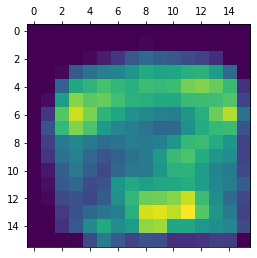

In [299]:
# from tqdm import tqdm
# files_ = os.listdir("/workstation/home/bijoy/data_from_b170007ec/Programs/Manoj/SQLEARNING/Imagenet/val")
# files_ = sorted(files_)
# img_dirs_ = []
# labels_ = []
# for i in tqdm(files_[k:k+1]):
#     path = "/workstation/home/bijoy/data_from_b170007ec/Programs/Manoj/SQLEARNING/Imagenet/val/" + str(i)
#     img = Image.open(path)
#     t2 = transforms.ToTensor()(img)
#     if t2.shape[0] == 3:
#         img_dirs_.append(path)
#         labels_.append(1)
# type1_txt = '/workstation/home/bijoy/data_from_b170007ec/Programs/Cervix Cancer/good_files1.txt'
# type2_txt = '/workstation/home/bijoy/data_from_b170007ec/Programs/Cervix Cancer/files2good.txt'
# type3_txt = '/workstation/home/bijoy/data_from_b170007ec/Programs/Cervix Cancer/good_files3.txt'
# test_data = []
# test_labels = []
# for class_,txt in enumerate([type1_txt,type2_txt,type3_txt]):
#     for i,dir_ in enumerate(pickle.load(open(txt,'rb'))):
#         dir_ = dir_.split('/')
#         dir_[0] = '/workstation'
#         dir_[1] = 'home'
#         dir_.insert(2,'bijoy')
#         dir_.insert(3,'data_from_b170007ec')
#         dir_.insert(6,'train')
#         if 'additional' in dir_[-3].split('_'):
#             dir_.remove(dir_[-2])
#         else:
#             dir_.remove(dir_[-3])
#         dir_ = '/'.join(dir_)
#         test_data.append(dir_)
#         test_labels.append(0)
        
additional_data = []
additional_label = []
bad_type1_txt = '/workstation/home/bijoy/data_from_b170007ec/Programs/Cervix Cancer/bad_files1.txt'
bad_type2_txt = '/workstation/home/bijoy/data_from_b170007ec/Programs/Cervix Cancer/files2bad.txt'
bad_type3_txt = '/workstation/home/bijoy/data_from_b170007ec/Programs/Cervix Cancer/bad_files3.txt'
for class_,txt in enumerate([bad_type1_txt,bad_type2_txt,bad_type3_txt]):
    for i,dir_ in enumerate(pickle.load(open(txt,'rb'))):
        dir_ = dir_.split('/')
        dir_[0] = '/workstation'
        dir_[1] = 'home'
        dir_.insert(2,'bijoy')
        dir_.insert(3,'data_from_b170007ec')
        dir_.insert(6,'train')
        if 'additional' in dir_[-3].split('_'):
            dir_.remove(dir_[-2])
        else:
            dir_.remove(dir_[-3])
        dir_ = '/'.join(dir_)
        additional_data.append(dir_)
        additional_label.append(1)
print("Length of additional data :",len(additional_data))
s = Scclassifier()
s.eval()
dataloader = DataLoader(PretrainingDatasetWrapper_cls(additional_data[k:k+1], additional_label[k:k+1],
                                            debug=getattr(hparams_cls, "debug", False)),
                          batch_size = 1,
                          shuffle=False,
                          num_workers=4,
                          sampler=SequentialSampler(list(range(len(additional_data)))),
                         drop_last=False)
img, label, path = next(iter(dataloader))
pred = s(img)

pred[:,0].backward(retain_graph = True)
print(pred.argmax(dim=1))
# pull the gradients out of the model
gradients = s.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = s.get_activations(img).detach()
# weight the channels by corresponding gradients
for i in range(1408):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)
# draw the heatmap
plt.matshow(heatmap.squeeze())
plt.show()


import cv2
img = cv2.imread(path[0])
img = cv2.resize(img,(512,512))
heatmap = cv2.resize(np.float32(heatmap), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.6 + img
im_v = np.concatenate((img, superimposed_img), axis=0)
cv2.imwrite('cervix{}.jpg'.format(k), im_v)
k+=1